# Table of Contents

1. [Introduction](#Introduction)

    a. [Environment Code Samples](#Environment-Code-Samples)
    
    
2. [Trajectory Optimization Constraints](#Trajectory-Optimization-Constraints)

    a. [Constraint 1: Avoiding Obstacles](#Constraint-1:-Avoiding-Obstacles)
    
    b. [Non-Rectangular Obstacles](#Non-Rectangular-Obstacles)
    
    c. [Potential Issue: Riding Adjacent Obstacle Edges](#Potential-Issue:-Riding-Adjacent-Obstacle-Edges)
    
    d. [Constraint 2: Obeying the Speed Limit](#Constraint-2:-Obeying-the-Speed-Limit)
    
    e. [Potential Issue: Clipping Obstacles](#Potential-Issue:-Clipping-Obstacles)
    
    f. [Constraint 3: Minimizing Distance](#Constraint-3:-Minimizing-Distance)
    
    g. [Methods for Solving Convex Optimization](#Methods-for-Solving-Convex-Optimization)
    
    
3. [Implementing Path Planning with MIQCP](#Implementing-Path-Planning-with-MIQCP)

    a. [Examples](#Examples)
    
    b. [Advanced Modeling](#Advanced-Modeling)
    
    c. [Alternate Obstacle Avoidance Encodings](#Alternate-Obstacle-Avoidance-Encodings)
    
    d. [Multi-Agent Example](#Multi-Agent-Example)

# Introduction

_The story so far..._

The year is 2032 and you are a mission specialist NASA astronaut on the surface of the Moon. Alongside the Artemis IV habitat, you and your crewmates have set up an array of geology stations around the habitat. These stations need servicing and sample collection every once in a while, a job that you've delegated to robots. It's your job to make sure that your autonomous robot mechanics can find their way to the stations while avoiding obstacles on the surface.

The rovers themselves have speed limits.

We'll be setting this problem up as a mixed integer quadratic constraint problem and solving it with SCIP and its Python interface, PySCIPOpt.

In [2]:
from descartes import PolygonPatch
import json
import math
import matplotlib
import numpy as np
from pyscipopt import Model, quicksum
import random
from shapely.geometry import Point
import environment

# get the obstacles, starting point, and goal region definitions
with open('notamoon.json') as f:
    notamoon = json.load(f)

## Environment Code Samples

Run the cells below to see the environment.

The next cell shows the actual environment we'll be using from now on.

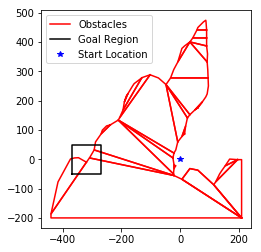

In [62]:
plt = matplotlib.pyplot
plt.figure()

for obs in notamoon['obstacles']:
    coord = np.array(obs['geometry']['coordinates'])
    plt.plot(coord[:,0], coord[:,1],'-r')
plt.gca().set_aspect('equal','box')
plt.draw()
line1,= plt.plot(coord[:,0],coord[:,1],'-r',label='Obstacles')

coord = np.array(notamoon['goal']['geometry']['coordinates'])
line2,=plt.plot(coord[:,0],coord[:,1],'k-',label='Goal Region')

line3,=plt.plot(0,0,'*b',label='Start Location')
plt.legend(handles=[line1,line2,line3],loc='best')

We will use the SCIP solver and its Python interface, PySCIPOpt, to solve the MIQCP. An example of `pyscipopt` is below.

In [63]:
# SCIP example from https://github.com/SCIP-Interfaces/PySCIPOpt/#building-and-solving-a-model

example_model = Model("example")

x = example_model.addVar("x")
y = example_model.addVar("y", vtype="INTEGER")
example_model.setObjective(x + y)
example_model.addCons(2*x - y*y >= 0)
example_model.optimize()
sol = example_model.getBestSol()
print("x: {}".format(sol[x]))
print("y: {}".format(sol[y]))

x: 0.0
y: 0.0


# Trajectory Optimization Constraints

The goal of trajectory optimization is to minimize a performance measure while satisfying constraints related to motion. In this case, we will be minimizing the total distance the robot travels to complete the mission while avoiding obstacles and respecting a speed limit. Thus, this gives us the three constraints of the problem:

1. Avoid all obstacles
2. Maintain a speed under the speed limit
3. Minimize the distance traveled between the start point and the end point

For this tutorial, we will assume a simplified view of the world with discrete time steps, polygon obstacles with straight edges, and no uncertainty.

Constraint 1, avoiding obstacles, ensures that the path is legal.

Constraint 2, keeping a speed limit, limits the distance traveled between time steps.

Constraint 3, minimizing distance traveled, ensures the solution is optimal given the encoding.

Accounting for these constraints depends on the way the problem is encoded. For obstacle avoidance, we will take a naïve approach of simply iterating over all the obstacles and defining unique constraints for each edge. At the end of this tutorial, we will briefly describe an alternative encoding that enables more performant calculations.

First though, rather than look at each edge of each obstacle, we will simplify the problem further and assume that each obstacle is a rectangle.

For this problem, we'll set the maximum amount of travel time to 16 minutes, the speed limit to 100 meters/minute, and use 1 minute time steps.

## Constraint 1: Avoiding Obstacles

We can assume all obstacles are quadrilaterals. The easiest obstacles to constrain are rectangles, but non-parallelograms can be approximated as rectangles by extending the sides until a rectangle is formed. Each side of the rectangle can be modeled as four intersecting lines. By defining these lines as inequalities, we can establish obstacles as no-go areas for the robot.
The obstacles are defined by the line equations that make up their sides.
These inequalities become our constraints for avoiding obstacles [1].

$\forall t \in [1 ..., T]:~x_t \leq x_{min}$ <br>
$or~x_i \geq x_{max}$ <br>
$or~y_i \leq y_{min}$ <br>
$or~y_i \geq y_{max}$ <br>

These constraints are 'or' statements, but 'and' statements are more useful for our purposes. We can transform the constraints from 'or' to 'and' by introducing binary slack variables ($t_i$) and $M$ (an arbitrarily large number). These constraints are also now mixed-integer/linear constraints, which allow us to put them in our optimization problem.

$\forall i \in [1 ..., N]:~x_i \leq x_{min}~+~M(1-t_{i1})$

$and~x_i \leq -x_{max}~+~M(1-t_{i2})$

$and~y_i \leq y_{min}~+~M(1-t_{i3})$

$and~-y_i \leq -y_{max}~+~M(1-t_{i4})$

$and \displaystyle \sum_i^4 t_i \geq 1$

The final part of the constraint, the sum over all $t_i \leq 1$, ensures that at least 1 of the binary variables is "chosen" for the obstacle, satisfying 1+ edge constraints.

### Non-Rectangular Obstacles

Of course, obstacles will rarely be rectangles. To be more realistic about avoiding obstacles, let's continue to assume they are polygons but remove the restriction that they are rectangles. We can still use binary slack variables to solve the optimization problem, but we will need to reformulate the way we determine whether or not a point is in the "safe region" outside an obstacle or within one.

To start, we can generalize the line formed between two points as

$$\vec{A}x - b = 0$$

Where $\vec{A}$ is essentially a vector describing the change in each component of a point, $\vec{x}$, and $b$ is an offset in each axis. Thus, to be within the "safe region," a point must meet the following constraint

$$\vec{A}x \leq b$$

Given two endpoints that a define a line, $p_0$ and $p_1$, we can write each point $p_i$, as $p_i = [x_i, y_i]$. We know the offset between the endpoints, $p$, and the line is $0$. Thus, if $\vec{A} = [a_x, a_y]$, then $b_0 = b_1$ and

$$
\begin{align}
\vec{A}(p_1-p_0) & = 0 \\
a_x(x_1-x_0) + a_y(y_1-y_0) & = 0 \\
a_x(x_1-x_0) & = -a_y(y_1-y_0) \\
\frac{a_x}{-(y_1-y_0)} & = \frac{a_y}{(x_1-x_0)} \\
\end{align}
$$

Thus we know we need

$$a_x = -(y_1-y_0)~and~a_y = (x_1-x_0)$$

Once we have $\vec{A}$, we can replace replace a known $p$ on the line (like the endpoints $p_0$ and $p_1$) to solve $\vec{A}x = b$ for $b$, at which point we have everything we need to use $\vec{A}x \leq b$ as a constraint.

#### Potential Issue: Riding Adjacent Obstacle Edges

In this encoding, we are treating the vehicle as point and the obstacles sizes have already taken the vehicle's shape and size into account. This is fine except in the situation where two obstacles share an edge. In this case, there is an infinitesimal line that satisfies the edge constraints for both obstacles, and we have an infinitesimal vehicle. As such, you see the vehicle take shortcuts such as the one below.

![vehicle is taking a shortcut on the line between adjacent obstacles](./shortcut.png)

To rectify this, we need to remove these infinitesimal lines on shared obstacles edges. We can do so by modifying our constraint to

$$\vec{A}x \leq b - \epsilon;~\epsilon \gt 0$$

where $\delta$ is a small value that radially grows each obstacle. Thus, overlaps are created between shared edges and we see behavior like this instead.

![vehicle goes around all obstacles](./no-shortcut.png)

## Constraint 2: Obeying the Speed Limit

In the problem given, we're told that the agent has a speed limit - in other words the robot has a limit on how much it can change its position, $d$, during a single time step. We are also ignoring vehicle dynamics when considering position changes. Thus position changes are allowed so long as the magnitude of the change in position is within $d \leq v_{max}*t$.

A speed limit is defined as a quadratic constraint. Consider the diagram below.

<img src="./speed-limit-quadratic-constraint.png" alt="Drawing" style="width: 200px;"/>

The circle shows the maximum distance the robot can travel within a time step. This limits the speed the robot can reach to the radius of the circle. The maximum velocity is $v_{max} = \sqrt{v_x^2 + v_y^2}$. In other words,

$$[\vec{x}_t - \vec{x}_{t-1}]^T [x_{t} - x_{t-1}] \leq d_{sq}$$

Where $d_{sq}$ is a variable representing the traversal distance squared. Rewriting our speed limit, we can now say that

$$d_{sq} \leq (S \Delta t)^2$$

Where $S$ is the speed limit and $\Delta t$ is the timestep size.

#### Potential Issue: Clipping Obstacles

As you can see in the results describing shortcuts, regardless of the encoding we see the vehicle cutting corners. This is due to a combination of the fact that the speed limit constraint could better be described as allowing a vehicle to "jump" $d_{sq}$ in any direction, so long as the start and end points both meet the rest of the constraints. Nowhere in our encoding are we checking the validity of the paths _between_ points, and as such we see the vehicle clipping corners. By increasing the additional $\delta$ above, we can reduce the amount of apparent corner clipping.

## Constraint 3: Minimizing Distance

The solver will determine the most optimal path for the robot to take to minimize distance travelled while still meeting the constraints. This distance is naturally represented with $d_{sq}$. Thus, the objective function is

$$\min \sum d_{sq}$$

## Methods for Solving Convex Optimization

By defining constraints in a convex space, we can take advantage of convex optimization methods, which can identify global maxima (or minima) within convex spaces. For a convex problem, taking small steps in the direction of greatest descent will eventually find the global minimum and any local minimum found is also a global minimum.

One method worth mentioning is the barrier method for finding interior points of non-linear convex spaces. In linear optimization, global maxima are found in corner points, which can be found using a variety of methods. The same is not true for non-linear spaces. As such, we have to go through the interior space and apply unconstrained interior point methods such as gradient descent to find maxima. Region boundaries pose a problem because they are non-differentiable. Intuitively, we are trying to minimize a system of equations, a Hessian matrix, where the sum of them should be $\leq 0$. If any function is run against a value outside the region, the system then could return infinity.

Rather than abruptly returning infinity for points outside the region, we can use a barrier method where we approximate the boundary of a region with a logarithmic function that approaches infinity as $x$ goes to $0$ and $0$ as x goes to $-1$ (or $1$, depending on how you set up the problem). The barrier method takes the form of:

$$\displaystyle \boldsymbol{x}' = \min_x~~f_0 - \frac{1}{t}\sum_{i=1}^m log(-f_i(\boldsymbol{x}))$$

The procedure you would follow the apply the barrier method is:

1. Initialize a feasible $\boldsymbol{x}$, small $t > 0$
2. Minimize the equation above using something like gradient descent
3. Make the barrier steeper by setting $\boldsymbol{x} = \boldsymbol{x}'$, $t = ut$ for some $u > 1$
4. If there is a convergence, return $\boldsymbol{x}$, else go to 2.

In our case, we could apply the barrier method for the non-linear speed limit constraint.

Other example methods for solving convex optimization include:

* Ellipsoid method: using smaller and smaller ellipsoids to limit the solution space within the convex set.
* Subgradient method: used when the convex fucntion is non-differentiable.
* Cutting plane: used to solve mixed integer linear programming by "cutting" off sections of the solution set to find the integer solution.

# Implementing Path Planning with MIQCP

Below, we'll implement the function

```python
miqcp(start_vector, obstacles, goal_region, max_time, timestep, speed_limit)
```

`miqcp` will take the following as parameters:

    starting_point []float list of x1, x2 initial values
    obstacles dict
    obstacles["geometry"] dict
    obstacles["geometry"]["coordinates"] [][]float
    goal_region dict
    goal_region["geometry"] dict
    goal_region["geometry"]["coordinates] dict
    max_time int
    timestep int
    speed_limit float

It will return a `pyscipopt.Model` and the variables in the solution.

In [65]:
def miqcp(start_vector, obstacles, goal_region, max_time, timestep, speed_limit):
    """
    Run a mixed-integer quadratic constraint program to solve motion planning in a 2-D environment
    
    Params:
        starting_point []float list of x1, x2 initial values
        obstacles dict
        obstacles["geometry"] dict
        obstacles["geometry"]["coordinates"] [][]float
        goal_region dict
        goal_region["geometry"] dict
        goal_region["geometry"]["coordinates] dict
        max_time int
        timestep int
        speed_limit float
    Returns:
        pyscipopt.Model
        variables [][]pyscipopt.Variable
    """
    # create the SCIP model for the basic encoding of this problem
    model = Model("motion-planning")

    # the variables are the position of the agent at each time step
    variables = []
    
    # extend b in constraint 1 by this amount
    epsilon = 5

    num_timesteps = math.ceil(max_time / timestep)
    for t in range(num_timesteps):
        # position
        x1 = model.addVar(f"x1-{t}", vtype="CONTINUOUS", lb=-500., ub=500.)
        x2 = model.addVar(f"x2-{t}", vtype="CONTINUOUS", lb=-500., ub=500.)

        # d^2 for the robot at a given timestep is limited by the speed limit
        d_sq = model.addVar(
            f"d_sq-{t}", vtype="CONTINUOUS", lb=0.0, ub=(speed_limit * timestep) ** 2
        )

        # set the starting point and initial velocity
        if t == 0:
            model.fixVar(x1, start_vector[0])
            model.fixVar(x2, start_vector[1])

        variables.append([x1, x2, d_sq])

    # CONSTRAINT 1 - obstacle edges

    # we want to create constraints for each obstacle, they are irregular polygons
    # but let's pretend they are rectangles instead
    for o, obstacle in enumerate(obstacles):
        # the given coordinates define a polygon, which means that the shape is closed
        # coordinates c are in order of c0, c1, ..., cN, c0. note they start and end on the same point
        coordinates = obstacle["geometry"]["coordinates"]

        As = []
        bs = []
        
        # solve Ax = b for this edge to get the constraint Ax <= b
        for c, coordinate in enumerate(coordinates):
            # the last coordinate is the same as the first so no need to continue
            if c == len(coordinates) - 1:
                break
            
            starting_point = coordinates[c]
            ending_point = coordinates[c+1]
            a_x = -(ending_point[1] - starting_point[1])
            a_y = (ending_point[0] - starting_point[0])
            b = (a_x * ending_point[0]) + (a_y * ending_point[1])
            As.append([a_x, a_y])
            bs.append(b)
            
        for v in variables:
            # an arbitrarily large variable
            M = 10000000.0

            slack_switches = [
                # binary slack variables, either 0 or 1
                model.addVar(f"y{o}{b}", vtype="B")
                for b in range(len(bs))
            ]

            for a, A in enumerate(As):
                # avoid obstacle edges using binary constraints
                # dither the radius to give the vehicle some physical size (a square)
                # note that these are AND'd together because all sides of the vehicle must avoid the obstacle
                # but the edges themselves are OR'd together using binary slack variables because the vehicle
                # is safe so long as it avoids at least one edge
                model.addCons((A[0] * (v[0])) + (A[1] * (v[1])) <= bs[a] - epsilon + (M * (1 - slack_switches[a])))

            # ensure that at least one y is 1 for this variable and obstacle
            model.addCons(sum([s for s in slack_switches]) >= 1)

    # for each variable, we'll set backward looking constraints - eg. we'll be constraining the position
    # of this timestep based on the position before it
    for t, variable in enumerate(variables):
        # don't worry about the first timestep because there isn't a time before it
        if t == 0:
            continue
        
        # CONSTRAINT 2 - speed limits as a constraint on the distance between positions at time stamps
        
        model.addCons(
            (variables[t][0] - variables[t - 1][0]) ** 2
            + (variables[t][1] - variables[t - 1][1]) ** 2
            <= variables[t][2]
        )
    
    # set a constraint on the final position such that it has to be inside the goal
    goal_coordinates = goal_region["geometry"]["coordinates"]
    last_timestamp = variables[-1]
    
    goal_As = []
    goal_bs = []
    
    # get the goal region
    for c, coordinate in enumerate(goal_coordinates):
        # the last coordinate is the same as the first so no need to continue
        if c == len(goal_coordinates) - 1:
            break

        starting_point = goal_coordinates[c]
        ending_point = goal_coordinates[c+1]
        a_x = -(ending_point[1] - starting_point[1])
        a_y = (ending_point[0] - starting_point[0])
        b = (a_x * ending_point[0]) + (a_y * ending_point[1])
        goal_As.append([a_x, a_y])
        goal_bs.append(b)

    # be inside the goal
    for a, A in enumerate(goal_As):
        model.addCons((A[0] * last_timestamp[0]) + (A[1] * last_timestamp[1]) >= goal_bs[a])

    # CONSTRAINT 3 as the objective function - minimize distance traveled

    model.setObjective(sum([v[2] for v in variables]), "minimize")
    
    model.hideOutput()
    model.optimize()
    
    print(f"this model is: {model.getStatus()}")

    return model, variables


start_vector = [0.0, 0.0]
# cut the number of obstacles in half
obstacles = [obstacle for o, obstacle in enumerate(notamoon["obstacles"]) if o >= 15 and o < 23]
# obstacles = notamoon["obstacles"
# obstacles = []
goal_region = notamoon["goal"]
# The maximum speed defined in meters/minute
speed_limit = 100
# The maximum amount of travel time defined in minutes
max_time = 16
# The discrete delta t in the constraints below defined in minutes
timestep = 1

model, variables = miqcp(start_vector, obstacles, goal_region, max_time, timestep, speed_limit)
print("Optimal value:", model.getObjVal())
for v in variables:
    for w in v:
        print(w.name, " = ", model.getVal(w))

this model is: optimal
Optimal value: 5449.258754262671
x1-0  =  0.0
x2-0  =  0.0
d_sq-0  =  0.0
x1-1  =  -16.399541220681414
x2-1  =  -7.943462556097685
d_sq-1  =  332.04354903989093
x1-2  =  -32.79925501672585
x2-2  =  -15.886536305707304
d_sq-2  =  332.04303252347495
x1-3  =  -49.198386579488584
x2-3  =  -23.829517415611093
d_sq-3  =  332.0224640703216
x1-4  =  -72.40071384969589
x2-4  =  -38.74918188276391
d_sq-4  =  760.9443783206052
x1-5  =  -91.41773431750406
x2-5  =  -40.60744033319004
d_sq-5  =  365.1001915519996
x1-6  =  -109.2759761285192
x2-6  =  -36.89337496913532
d_sq-6  =  332.7110818557361
x1-7  =  -127.1337828670205
x2-7  =  -33.17940008922632
d_sq-7  =  332.694870532534
x1-8  =  -144.99250730336362
x2-8  =  -29.465234351235942
d_sq-8  =  332.7290650424238
x1-9  =  -162.85077929874956
x2-9  =  -25.751162709590893
d_sq-9  =  332.7122064745445
x1-10  =  -180.70850345257696
x2-10  =  -22.037205005218006
d_sq-10  =  332.69179321123556
x1-11  =  -198.5672431827399
x2-11  = 

Now let's plot.

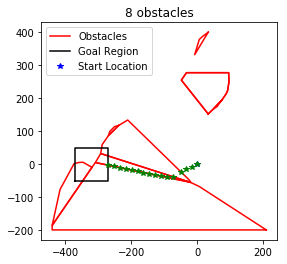

In [66]:
def plot(model, variables, start_vector, goal_region, obstacles):
    result_plt = matplotlib.pyplot
    result_plt.figure()

    for obs in obstacles:
        coord = np.array(obs['geometry']['coordinates'])
        result_plt.plot(coord[:,0], coord[:,1],'-r')

    result_plt.gca().set_aspect('equal','box')
    result_plt.draw()

    coord = np.array(obstacles[0]['geometry']['coordinates'])
    line1, = result_plt.plot(coord[:,0], coord[:,1],'-r', label='Obstacles')

    coord = np.array(goal_region['geometry']['coordinates'])
    line2, = result_plt.plot(coord[:,0], coord[:,1],'k-', label='Goal Region')

    line3, = result_plt.plot(start_vector[0], start_vector[1], '*b', label='Start Location')

    for v in variables:
        result_plt.plot(model.getVal(v[0]), model.getVal(v[1]), '*g')

    result_plt.legend(handles=[line1, line2, line3], loc='best')
    result_plt.title(f"{len(obstacles)} obstacles")

# plot(model, variables)
plot(model, variables, start_vector, goal_region, obstacles)

The result above was generated to show a shortcut being taken without using an $\epsilon$.

## Examples

Below, we'll go through various selections of obstacles, speed limits, and timesteps to show the behavior of MIQCP path planning. (Note: these were run with an older version of `plot` so the function arguments aren't quite the same.)

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal


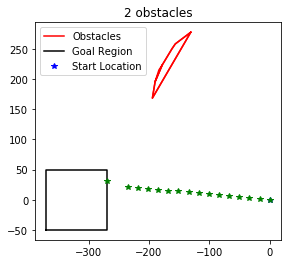

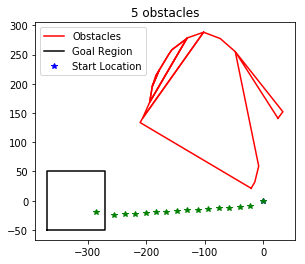

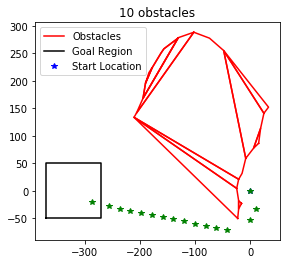

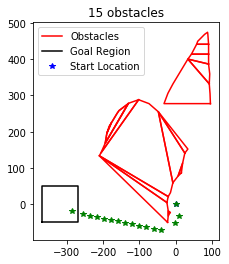

In [9]:
for i in [2, 5, 10, 15]:
    start_vector = [0.0, 0.0]
    # cut the number of obstacles in half
    obstacles = [obstacle for o, obstacle in enumerate(notamoon["obstacles"]) if o < i]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 100
    # The maximum amount of travel time defined in minutes
    max_time = 16
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region)

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal


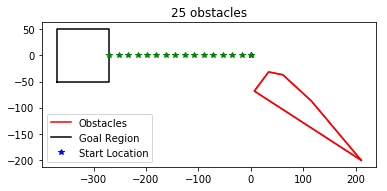

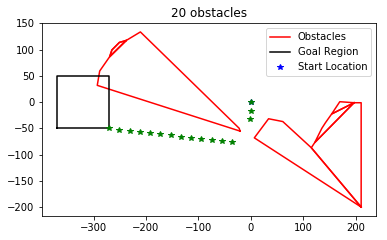

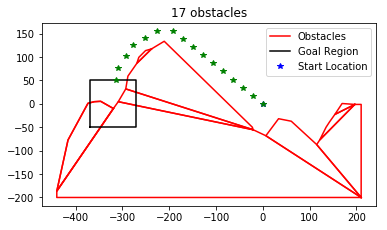

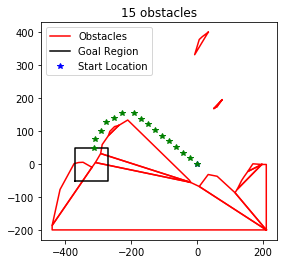

In [10]:
for i in [25, 20, 17, 15]:
    start_vector = [0.0, 0.0]
    # cut the number of obstacles in half
    obstacles = [obstacle for o, obstacle in enumerate(notamoon["obstacles"]) if o > i]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 100
    # The maximum amount of travel time defined in minutes
    max_time = 16
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region)

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal


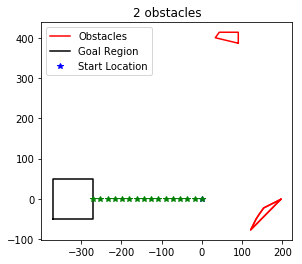

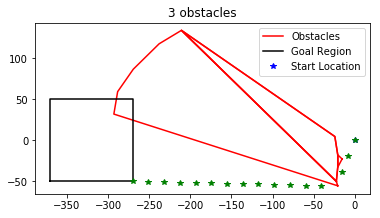

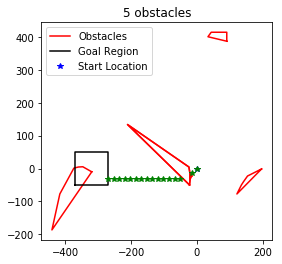

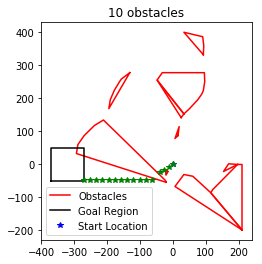

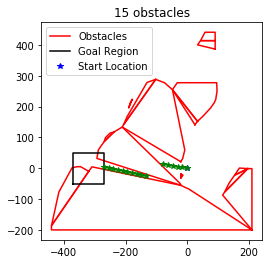

In [26]:
for i in [2, 3, 5, 10, 15]:
    obstacles = notamoon["obstacles"].copy()
    random.shuffle(obstacles)
    random_obstacles = obstacles[:i]
    start_vector = [0.0, 0.0]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 100
    # The maximum amount of travel time defined in minutes
    max_time = 16
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, random_obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region, random_obstacles)

The last example here shows an extreme version of obstacle clipping. The $d_{sq}$ between the points apparently meets constraint 3, so this is a valid path according to our model.

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal
this model is: infeasible


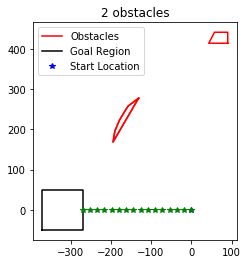

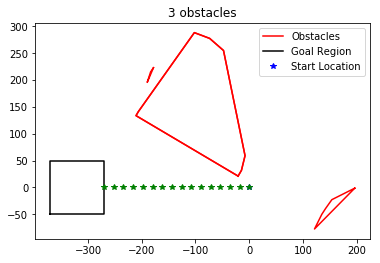

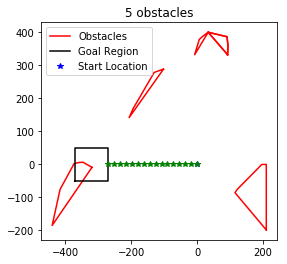

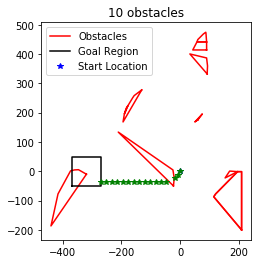

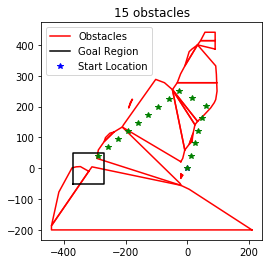

In [27]:
for i in [2, 3, 5, 10, 15]:
    obstacles = notamoon["obstacles"].copy()
    random.shuffle(obstacles)
    random_obstacles = obstacles[:i]
    start_vector = [0.0, 0.0]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 50
    # The maximum amount of travel time defined in minutes
    max_time = 16
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, random_obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region, random_obstacles)

Note: the last example here is infeasible. The reduced speed limit does not allow the vehicle to reach the goal while satisfying all constraints.

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal


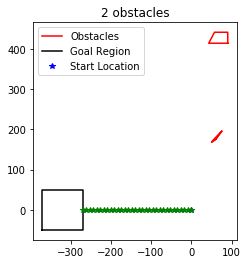

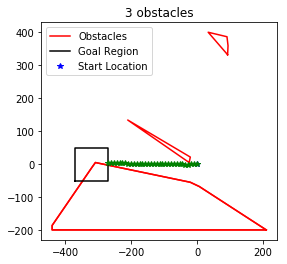

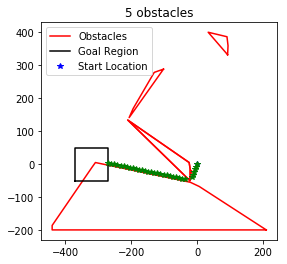

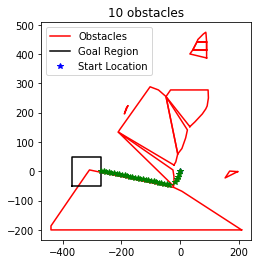

In [28]:
for i in [2, 3, 5, 10]:
    obstacles = notamoon["obstacles"].copy()
    random.shuffle(obstacles)
    random_obstacles = obstacles[:i]
    start_vector = [0.0, 0.0]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 25
    # The maximum amount of travel time defined in minutes
    max_time = 32
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, random_obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region, random_obstacles)

this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal
this model is: optimal


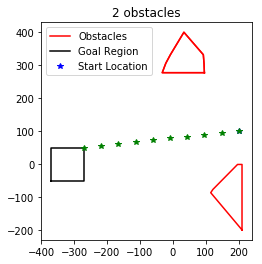

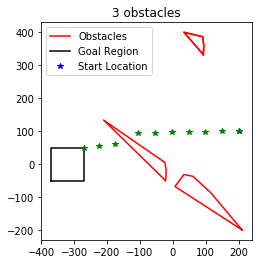

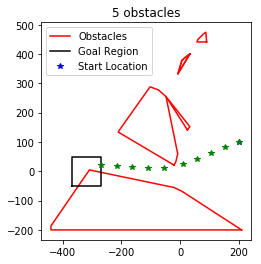

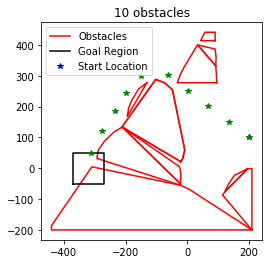

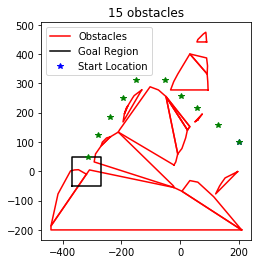

In [37]:
for i in [2, 3, 5, 10, 15]:
    obstacles = notamoon["obstacles"].copy()
    random.shuffle(obstacles)
    random_obstacles = obstacles[:i]
    start_vector = [200.0, 100.0]
    goal_region = notamoon["goal"]
    # The maximum speed defined in meters/minute
    speed_limit = 100
    # The maximum amount of travel time defined in minutes
    max_time = 10
    # The discrete delta t in the constraints below defined in minutes
    timestep = 1

    model, variables = miqcp(start_vector, random_obstacles, goal_region, max_time, timestep, speed_limit)
    plot(i, model, variables, start_vector, goal_region, random_obstacles)

The 3 obstacle example shows a particularly egregious example of obstacle clipping.

## Advanced Modeling

This was just one approach to the problem of path planning using MIQCP. In it, we applied the following simplifications:

1. We assumed a single agent
2. We assumed static obstacles
3. We assumed discrete timesteps
4. We assumed a deterministic (non-stochastic) environment
5. We assumed a simplistic motion model
6. We assumed we wanted to minimize distance
7. We did not use a limited horizon for planning

The methods we applied here for the simple problem can be extended to relax our simplifications. Let's discuss how we might model the problem differently for these cases.

### 1. Multiple Agents

If we wanted multiple agents moving in the environment, we can add additional constraints that restrict the ability for two agents to be in the same place at the same time. This could be as simple as iterating over every agent at every timestep and adding a new constraint to not be at the same location as any other agent. Or we could define a "minimum safe distance" that each agent must keep around one another. For minimum safe distances of $d_x$ and $d_y$ and vehicles $p$ and $q$ this may look like so:

$$\forall i \in [i, ..., N]~:~\forall p,q | q > p : |x_{pi} - x_{qi}| \geq d_x~or~|y_{pi} - y_{qi}| \geq d_y$$

Like the obstacle avoidance constraints from before, you can convert these into "and" constraints by introducing binary variables, $b_{pqik}$.

$\forall i \in [1, ... N]~:~\forall p,q|q>p~:$ </br>

$x_{pi} - x_{qi} \geq d_x - M (1 - b_{pqi1})$ </br>

$and~x_{qi} - x_{pi} \geq d_x - M (1 - b_{pqi2})$ </br>

$and~y_{pi} - y_{qi} \geq d_y - M (1 - b_{pqi3})$ </br>

$and~y_{qi} - y_{qi} \geq d_y - M (1 - b_{pqi4})$ </br>

$\displaystyle and~\sum_{k=1}^4 b_{pqik} \geq 1$

You can find a demonstration of `multi_vehicle_miqcp` below with two vehicles below.

### 2. Non-Static Obstacles

Not all obstacles are stationary and we have a few different ways of modeling them. One approach would be to simply re-define obstacle constraints at every time step using predefined knowledge of the way the obstacles are moving. For instance, if the dynamic model of each obstacle was known (see section 5 below), their motion could be simulated over each time step. This would enable the solver to "predict" each obstacle's location at a particular time, and thus adjust the obstacle avoidance constraints accordingly at each time step.


### 3. Continuous Timesteps

In real scenarios, and especially for long-horizon planning, the path planning problem needs to be modeled in continuous timesteps rather than discrete timesteps. Like moving from $dx$ to $\delta x$ in calculus, we can model continuous time by modifying our constraints related to the speed limit. Given a time, $\tau_i$

$$[\vec{x}_t - \vec{x}_{t-1}]^T [x_{t} - x_{t-1}] \leq S^2 \tau_i^2$$

The other constraints can be framed in terms of continuous timesteps in likewise manner. However, the solving method used above is not applciable to continuous timestep problems. Thus, a different solver would have to be used, such as Scotty [2], that can handle continuous motion. Scotty assumes that state trajectories are piecewise linear. Thus, control inputs/path waypoints are still generated at fixed, discrete times, but the continuous motion in between the timesteps is considered in the solution. This method also permits Scotty to produce both continuous (e.g. navigation) and discrete (e.g. activity selection) planning tasks.

### 4. Stochastic Environment

In reality, autonomous vehicles do not operate in purely deterministic environments. Obstacle information, such as geometry, location, and motion may be imprecise or unknown. Additionally, the vehicle dynamics (see section 5 below) are often imprecise in that they are a linearized approximation of truly non-linear dynamics. Therefore, a motion planner must take these uncertainties into account when developing a trajectory. 

This is generally a difficult problem. Motion planners in uncertain environments often directly incorporate estimation algorithms (e.g. filtering) into the solver. For instance, Du Toit and Burdick present a motion planner for uncertain environments that uses receding horizon control. Prediction and estimation of obstacle motion as well as the actual trajectory planning are all incorporated into the receding horizon control method. More details on receding horizon control are presented in section 7 (see below). For more details on Du Toit and Burdick's uncertain environment motion planner, see reference [3].

### 5. Vehicle Dynamics

In defining our speed limit, we implicitly allowed motion along any axis. This assumption does not hold up for vehicle dynamics, which generally limit the turning radius of a vehicle motion. In more realistic settings, we would need to incorporate constraints on vehicle motion that better reflect vehicle dynamics. You could model this with a constraint like:

$$|\vec{v}_{t} - \vec{v}_{t-1}| \leq \alpha$$

Where $\alpha$ is a turning radius limit.

More generally, vehicle dynamics can be modeled as a state-space system:

$$ \dot{x} = Ax + Bu $$

Where $A$ and $B$ are constant matrices, $x$ is the vehicle's state (e.g. position and velocity), and $u$ is a control input (e.g. applying the gas pedal on a car). Enforcing this equation as a constraint for each time step ensures that the resulting path is dynamically feasible. Moving obstacles can also be represented in the same manner. This permits their motion to be predicted by the solver and thus avoided at each time step. Finally, using this representation, the motion planning problem could be framed to solve for individual control inputs $u$ to reach the goal. Instead of simply calculating waypoints at each time step, solving for control inputs results in a lower-level, physically-based motion planner. Additional constraints can then be added on the control inputs (i.e. actuation constraints).

$A$ and $B$ can be determined through system identification given that the system is linear and time-invariant. For simple scenarios, the matrices can easily be determined through laws of motion. As an example, consider a state variable $x$ that consists of a 1-D position $r$ and speed $v$. The state equation for $r$ is:

$$ \dot{r} = v $$

For $v$, the change in velocity (i.e. acceleration) is defined by the object's mass $m$ and the force enacted upon the object $F$. In this example, we can represent $F$ as the control input $u$. Therefore, the state equation for $v$ is: 

$$ \dot{v} = \frac{u}{m} $$

Combining the state equations produces the following:

$$ \dot{x} = \left[\begin{matrix} \dot{r} \\ \dot{v} \end{matrix}\right] = A\left[\begin{matrix} r \\ v \end{matrix}\right] + Bu$$

Finally, the resulting $A$ and $B$ matrices for this example are:

$$ A = \left[\begin{matrix} 0 & 1 \\ 0 & 0 \end{matrix}\right], ~B = \left[\begin{matrix} 0 \\ \frac{1}{m} \end{matrix}\right] $$

### 6. Minimizing Cost

While minimizing distance broadly corresponds to minimizing traversal cost, we could more explicitly model the cost of motion through something like fuel usage. Each step would therefore be associated with a fuel cost and the objective function would minimize fuel costs over the entire path. Fuel cost could be calculated as a function of position, velocity, and vehicle state (think how delivery truck fuel usage depends on load). The fuel cost function could also take into account terrain models, where other factors, such as terrain grade, would affect fuel costs.

The objective function is often modeled as a quadratic, for example:
$$\min \sum u^2$$
where $u$ is the cost variable. This ensures that the objective function is convex, thus being straightforward to find a minimum value. For this same reason, we modeled the objective function for the vehicle planning problem as minimizing the squared distance of the vehicle's trajectory.


### 7. Planning Horizon

It may be the case that it is either computationally infeasible or undesirable to calculate the full path offline. Additionally, as mentioned in section 4 above, planning in uncertain environments may require the original path to be updated as more information is gathered. If so, we can model path planning using a receding horizon on the timesteps, where the path is planned for the next $N$ timesteps, and planning repeated is periodically online [1].

Generating a path for only a limited horizon results in much faster computation times. However, this generally results in a non-optimal trajectory, as only parts of the trajectory are considered at a time. Moreover, limited horizon planning technically does not guarantee collision avoidance. For instance, if a path is planned for a certain number of time-steps and the vehicle moves close to the obstacle, the next iteration of path planning may not be able to move around the obstacle in a dynamically feasible way.


References:
 
[1] Schouwenaars, T., De Moor, B. D., Feron, E. and How, J., "Mixed Integer Programming for Multi-Vehicle Path Planning," Proceedings of the European Control Conference, 2001, pp. 2603-2608.

[2] Fernandez-Gonzalez, E., Karpas, E., and Williams, B., "Mixed Discrete-Continuous Planning with Convex Optimization," Proceedings of 31st AAAI Conference on Artificial Intelligence, 2017, pp. 4574-4580.  

[3] Du Toit, N. E., Burdick, J. W., "Robotic Motion Planning in Dynamic, Uncertain Environments," IEEE Transactions on Robotics, Vol. 28, No. 1, 2012, pp. 101-115, doi: 10.1109/TRO.2011.2166435.

## Alternate Obstacle Avoidance Encodings

There are obviously issues with this approach. Note that defining an environment with M obstacles with K edges over N timesteps creates $K * M * N$ edge constraints. In more realistic environments, this can create serious performance problems.

Scotty encodes a more performant encoding of obstacle avoidance. It does so by redefining the problem of obstacle avoidance as a series of transitions between free regions.

To do so, it first offline defines regions of overlapping free space between obstacles. It then applies a constraint that says that the agent must take the shortest path from one free space region to another. Given that each free space region will overlap with 1+ other regions, the agent effectively jumps from one overlap to another, taking the shortest path to the goal.

![overlapping regions](./scotty-example.png)

In this example, the free regions are represented as translucent boxes with dashed outlines between the blue obstacles. The start point in the smiley face and the goal is the star. The blue dots are centered on overlapping regions and the line shows the path between them. Note that this isn't the shortest path - the blue dots were picked to be in the center of overlapping regions to make it more obvious that this is where the regions are overlapping.

## Multi-Agent Example

Here, we'll run two vehicles with paths that cross to demonstrate how to encode multi-vehicle avoidance. We will encode the safe region around each vehicle as a square for simplicity's sake.

In [4]:
def multi_vehicle_plot(model, variables, start_vectors, goal_regions, obstacles):
    result_plt = matplotlib.pyplot
    result_plt.figure()

    for obs in obstacles:
        coord = np.array(obs['geometry']['coordinates'])
        result_plt.plot(coord[:,0], coord[:,1],'-r')

    result_plt.gca().set_aspect('equal','box')
    result_plt.draw()

    coord = np.array(obstacles[0]['geometry']['coordinates'])
    result_plt.plot(coord[:,0], coord[:,1],'-r', label='Obstacles')

    for g in goal_regions:
        coord = np.array(g['geometry']['coordinates'])
        result_plt.plot(coord[:,0], coord[:,1],'k-', label='Goal Region')

    for v in start_vectors:
        result_plt.plot(v[0], v[1], '*b', label='Start Location')

    for i, vehicle in enumerate(variables):
        marker = '.g' if i % 2 else '.c'
        for timestep in vehicle:
            result_plt.plot(model.getVal(timestep[0]), model.getVal(timestep[1]), marker)

    result_plt.title(f"{len(obstacles)} obstacles | {len(variables)} vehicles")

this model is: optimal
Optimal value: 33995.14435294818
0-x1-0  =  170.0
0-x2-0  =  300.0
0-d_sq-0  =  0.0
0-x1-1  =  126.76542991126603
0-x2-1  =  292.8201068108706
0-d_sq-1  =  1920.778916550178
0-x1-2  =  83.53118297273136
0-x2-2  =  285.64054910557155
0-d_sq-2  =  1920.7461564789774
0-x1-3  =  40.29699348990323
0-x2-3  =  278.460747931755
0-d_sq-3  =  1920.7446846732605
0-x1-4  =  -2.937145841231348
0-x2-4  =  260.1701381207055
0-d_sq-4  =  2203.7372104881033
0-x1-5  =  -33.6719332562704
0-x2-5  =  241.87885397426106
0-d_sq-5  =  1279.1982323416469
0-x1-6  =  -64.40579174879085
0-x2-6  =  223.58784988584557
0-d_sq-6  =  1279.1308876542053
0-x1-7  =  -95.14010209231152
0-x2-7  =  205.2976316407853
0-d_sq-7  =  1279.1299150921004
0-x1-8  =  -125.87419368005037
0-x2-8  =  187.00635342342528
0-d_sq-8  =  1279.1552435705007
0-x1-9  =  -156.6085234088495
0-x2-9  =  168.7157375768404
0-d_sq-9  =  1279.1456513503126
0-x1-10  =  -187.34332471035427
0-x2-10  =  150.42503102576578
0-d_sq-10  

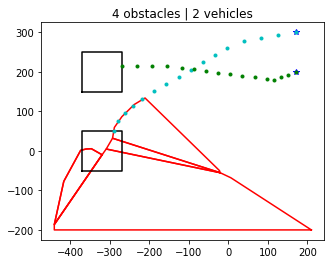

In [5]:
def multi_vehicle_miqcp(start_vectors, obstacles, goal_regions, max_time, timestep, speed_limit):
    """
    Run a mixed-integer quadratic constraint program to solve motion planning in a 2-D environment
    
    Params:
        starting_point []float list of x1, x2 initial values
        obstacles dict
        obstacles["geometry"] dict
        obstacles["geometry"]["coordinates"] [][]float
        goal_region dict
        goal_region["geometry"] dict
        goal_region["geometry"]["coordinates] dict
        max_time int
        timestep int
        speed_limit float
    Returns:
        pyscipopt.Model
        variables [][]pyscipopt.Variable
    """
    # create the SCIP model for the basic encoding of this problem
    model = Model("motion-planning")

    # the variables are the position of each agent at each time step
    # [][]variables
    variables = []
    
    # extend b in constraint 1 by this amount
    delta = 5

    # an arbitrarily large variable
    M = 10000000.0
    
    num_timesteps = math.ceil(max_time / timestep)
    
    for v, start_vector in enumerate(start_vectors):
        vehicle_variables = []
        for t in range(num_timesteps):
            # position
            x1 = model.addVar(f"{v}-x1-{t}", vtype="CONTINUOUS", lb=-500., ub=500.)
            x2 = model.addVar(f"{v}-x2-{t}", vtype="CONTINUOUS", lb=-500., ub=500.)

            # d^2 for the robot at a given timestep is limited by the speed limit
            d_sq = model.addVar(
                f"{v}-d_sq-{t}", vtype="CONTINUOUS", lb=0.0, ub=(speed_limit * timestep) ** 2
            )

            # set the starting point and initial velocity
            if t == 0:
                model.fixVar(x1, start_vector[0])
                model.fixVar(x2, start_vector[1])

            vehicle_variables.append([x1, x2, d_sq])
        variables.append(vehicle_variables)

    # CONSTRAINT 1 - obstacle edges

    # we want to create constraints for each obstacle, they are irregular polygons
    # but let's pretend they are rectangles instead
    for o, obstacle in enumerate(obstacles):
        # the given coordinates define a polygon, which means that the shape is closed
        # coordinates c are in order of c0, c1, ..., cN, c0. note they start and end on the same point
        coordinates = obstacle["geometry"]["coordinates"]

        As = []
        bs = []
        
        # solve Ax = b for this edge to get the constraint Ax <= b
        for c, coordinate in enumerate(coordinates):
            # the last coordinate is the same as the first so no need to continue
            if c == len(coordinates) - 1:
                break
            
            starting_point = coordinates[c]
            ending_point = coordinates[c+1]
            a_x = -(ending_point[1] - starting_point[1])
            a_y = (ending_point[0] - starting_point[0])
            b = (a_x * ending_point[0]) + (a_y * ending_point[1])
            As.append([a_x, a_y])
            bs.append(b)

        for vehicle in variables:
            for t, timestep in enumerate(vehicle):
                slack_switches = [
                    # binary slack variables, either 0 or 1
                    model.addVar(f"y{v}{o}{b}", vtype="B")
                    for b in range(len(bs))
                ]

                for a, A in enumerate(As):
                    # avoid obstacle edges using binary constraints
                    # dither the radius to give the vehicle some physical size (a square)
                    # note that these are AND'd together because all sides of the vehicle must avoid the obstacle
                    # but the edges themselves are OR'd together using binary slack variables because the vehicle
                    # is safe so long as it avoids at least one edge
                    model.addCons((A[0] * (timestep[0])) + (A[1] * (timestep[1])) <= bs[a] - delta + (M * (1 - slack_switches[a])))

                # ensure that at least one y is 1 for this variable and obstacle
                model.addCons(sum([s for s in slack_switches]) >= 1)

    # for each variable, we'll set backward looking constraints - eg. we'll be constraining the position
    # of this timestep based on the position before it
    for v, vehicle in enumerate(variables):
        for t, timestep in enumerate(vehicle):
            # don't worry about the first timestep because there isn't a time before it
            if t == 0:
                continue

            # CONSTRAINT 2 - speed limits as a constraint on the distance between positions at time stamps

            model.addCons(
                (variables[v][t][0] - variables[v][t - 1][0]) ** 2
                + (variables[v][t][1] - variables[v][t - 1][1]) ** 2
                <= variables[v][t][2]
            )
    
    # CONSTRAINT 4 - vehicles avoid each other
    
    # avoid the other vehicles
    for v, vehicle in enumerate(variables):
        for t, timestep in enumerate(vehicle):
            for w, other_vehicle in enumerate(variables):
                if w == v:
                    # this is the same vehicle, so move on
                    continue

                # assume the other vehicle is a square and avoid each side by some safety margin, S
                slack_switches = [
                    model.addVar(f"y{v}{w}{t}", vtype="B")
                    for b in range(4)
                ]
                
                # make S large so there is a large safe space around each vehicle
                S = 100

                # use the same binary slack variable technique that is applied to obstacles
                model.addCons(timestep[0] <= other_vehicle[t][0] - S + (M * (1 - slack_switches[0])))
                model.addCons(-timestep[0] <= -(other_vehicle[t][0] + S) + (M * (1 - slack_switches[1])))
                model.addCons(timestep[1] <= other_vehicle[t][1] - S + (M * (1 - slack_switches[2])))
                model.addCons(-timestep[1] <= -(other_vehicle[t][1] + S) + (M * (1 - slack_switches[3])))
                
                # ensure that at least one y is 1 for these two vehicles at this timestep
                model.addCons(sum([s for s in slack_switches]) >= 1)

    for g, goal_region in enumerate(goal_regions):
        # set a constraint on the final position such that it has to be inside the goal
        goal_coordinates = goal_region["geometry"]["coordinates"]
        last_timestamp = variables[g][-1]

        goal_As = []
        goal_bs = []

        # get the goal region
        for c, coordinate in enumerate(goal_coordinates):
            # the last coordinate is the same as the first so no need to continue
            if c == len(goal_coordinates) - 1:
                break

            starting_point = goal_coordinates[c]
            ending_point = goal_coordinates[c+1]
            a_x = -(ending_point[1] - starting_point[1])
            a_y = (ending_point[0] - starting_point[0])
            b = (a_x * ending_point[0]) + (a_y * ending_point[1])
            goal_As.append([a_x, a_y])
            goal_bs.append(b)

        # be inside the goal
        for a, A in enumerate(goal_As):
            model.addCons((A[0] * last_timestamp[0]) + (A[1] * last_timestamp[1]) >= goal_bs[a])

    # CONSTRAINT 3 as the objective function - minimize distance traveled overall

    model.setObjective(sum([v[2] for s in variables for v in s]), "minimize")
    
    model.hideOutput()
    model.optimize()
    
    print(f"this model is: {model.getStatus()}")

    return model, variables


start_vectors = [[170, 300.0], [170.0, 200.0]]

# pick which obstacles to use
obstacles_to_keep = [18, 19, 20, 22]

obstacles = [obstacle for o, obstacle in enumerate(notamoon["obstacles"]) if o in obstacles_to_keep]

goal_region1 = notamoon["goal"]
goal_region2 = {"geometry": {"coordinates": [
    [-370.0, 150.0],
    [-270.0, 150.0],
    [-270.0, 250.0],
    [-370.0, 250.0],
    [-370.0, 150.0]
]}}

goal_regions = [goal_region1, goal_region2]

# The maximum speed defined in meters/minute
speed_limit = 100
# The maximum amount of travel time defined in minutes
max_time = 16
# The discrete delta t in the constraints below defined in minutes
timestep = 1

model, variables = multi_vehicle_miqcp(start_vectors, obstacles, goal_regions, max_time, timestep, speed_limit)
print("Optimal value:", model.getObjVal())
for vehicles in variables:
    for v in vehicles:
        for w in v:
            print(w.name, " = ", model.getVal(w))

multi_vehicle_plot(model, variables, start_vectors, goal_regions, obstacles)

In the example above, you can see the vehicles adjust their paths early on to avoid each other later.